## Project: Toxic Comment Filter

In [ ]:
# check GPU runtime
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jun 12 07:36:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Costruire un modello in grado di filtrare i commenti degli utenti in base al grado di dannosità del linguaggio:
1. Preprocessare il testo eliminando l'insieme di token che non danno contributo significativo a livello semantico
2. Trasformare il corpus testuale in sequenze
3. Costruire un modello di Deep Learning comprendente dei layer ricorrenti per un task di classificazione multilabel
4. In prediction time, il modello deve ritornare un vettore contenente un 1 o uno 0 in corrispondenza di ogni label presente nel dataset (toxic,	severe_toxic,	obscene,	threat,	insult,	identity_hate). In questo modo, un commento non dannoso sarà classificato da un vettore di soli 0 [0,0,0,0,0,0]. Al contrario, un commento pericoloso presenterà almeno un 1 tra le 6 labels.

In [ ]:
!pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.8 MB/s eta 0:00:00


In [ ]:
#Import library

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense ,Embedding, Flatten
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
import itertools #per generare combinazioni di valori




from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:

BASE_URL = "https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/"
df = pd.read_csv(BASE_URL+"Filter_Toxic_Comments_dataset.csv")
df.head(15)


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0
5,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,4
7,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,0
8,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,0
9,alignment on this subject and which are contra...,0,0,0,0,0,0,0


In [ ]:
#df = pd.read_csv("Filter_Toxic_Comments_dataset.csv")
#df.head(15)

### <span style="background-color: yellow; color: black; font-weight: bold;">Check Dataframe</span>

In [ ]:
for column in df.columns[1:-1]:

    if (df[column] == 0).sum() + (df[column] == 1).sum() != df.shape[0]:
        raise Exception()

print("valori comrpesi tra 0 e 6 colonna 'sum_injurious'?")
df['sum_injurious'].value_counts()

print("valori mancanti?")
df['sum_injurious'].value_counts().sum() - df.shape[0]


valori comrpesi tra 0 e 6 colonna 'sum_injurious'?


sum_injurious
0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: count, dtype: int64

valori mancanti?


0

Il Dataset sembra essere sbilanciato con valori principalemnte situati nella classe "0", ovvero la classe appartenenti alle frasi che non contengono commenti negativi.



### <span style="background-color: yellow; color: black; font-weight: bold;">Data Preprocessing: Embeddings</span>

Gli embeddings sono rappresentazioni vettoriali densi di oggetti (come parole o frasi) in uno spazio a bassa dimensione. Sono creati per catturare le proprietà semantiche e sintattiche delle parole, in modo che parole simili abbiano rappresentazioni vettoriali simili.

<span style="color: #99CC99; font-weight: bold;">*NOTA: Differenza tra num_words e tokenizer.word_index*</span>


* <span style="color: #11FF12; font-weight: bold;">num_words: </span>


Questo parametro limita il numero di parole che il tokenizer considererà durante la tokenizzazione. Se si imposta num_words=1500, il tokenizer terrà conto solo delle 1500 parole più frequenti nel corpus.
Questo parametro è utilizzato solo durante la conversione di testi in sequenze (texts_to_sequences). Non influenza direttamente la costruzione del dizionario (word_index).

* <span style="color: #11FF12; font-weight: bold;">tokenizer.word_index: </span>

Questo dizionario contiene tutte le parole presenti nel corpus, indipendentemente dal valore di num_words. Ogni parola è associata a un indice unico basato sulla sua frequenza nel corpus.
La lunghezza di questo dizionario (len(tokenizer.word_index)) riflette il numero totale di parole uniche nel corpus, non solo le più frequenti.

* ###  Label Encoder

Applico una trasformazione alle classi in modo tale da ottenere, per ogni osservazione, un solo valore della classe di appartenenza.

Questa trasformazione è utile soprattutto per poter usare il parametro "stratify" della funzione "train_test_split" in modo tale da bilanciare il più possibile le classi passate in fase di addestramento

In [ ]:
X = df['comment_text'].values
y = df.drop(['comment_text', 'sum_injurious'], axis=1).values


# Genera tutte le combinazioni binarie di lunghezza 6
combinations = [''.join(seq) for seq in itertools.product('01', repeat=6)]

# Crea il dizionario di mappatura
mapping_label = {comb: i for i, comb in enumerate(combinations)}

#trasforma il vettore numpy in una lista di sequenze
y_sequence = [''.join(map(str, sublista)) for sublista in y.tolist()]

y = np.array([mapping_label[a] for a in y_sequence ])


Elimino le osservazioni la cui classe ha frequenza 1 al fine di poter usare il parametro "stratify"

In [ ]:
unique_values, counts = np.unique(y, return_counts=True)

# Identificare i valori con un solo elemento
values_with_one_count = unique_values[counts == 1]

# Trovare gli indici originali di questi valori
index = np.where(np.isin(y, values_with_one_count))[0]

# Mostrare i risultati
print("Valori con un solo conteggio:", values_with_one_count)
print("Indici degli elementi con un solo conteggio:", index)

# Cancellare le righe agli indici individuati
X = np.delete(X, index.tolist(), axis=0)
y = np.delete(y, index.tolist(), axis=0)



Valori con un solo conteggio: [53 54]
Indici degli elementi con un solo conteggio: [107881 134459]


### <span style="background-color: yellow; color: black; font-weight: bold;">Long Short Term Memory Neural Network</span>



* Long Short Term Memory model

* * ARCHITETTURA 1

In [ ]:
def get_LSTM_model_1(vocabulary_size, output_dim, maxlen, opt, loss_function, list_metrics, number_of_classes):
    clear_session()
    model_LSTM = Sequential()
    model_LSTM.add(Embedding(vocabulary_size+1, output_dim, input_length=maxlen))
    model_LSTM.add(Bidirectional(LSTM(16, activation='tanh')))
    model_LSTM.add(Dense(number_of_classes, activation='softmax'))
    model_LSTM.compile(optimizer=opt, loss=loss_function, metrics=list_metrics)
    return model_LSTM

* * ARCHITETTURA 2

In [ ]:
def get_LSTM_model_2(vocabulary_size, output_dim, maxlen, opt, loss_function, list_metrics, number_of_classes):
    clear_session()
    model_LSTM = Sequential()
    model_LSTM.add(Embedding(vocabulary_size+1, output_dim, input_length=maxlen))
    model_LSTM.add(Bidirectional(LSTM(16, activation='tanh')))
    model_LSTM.add(Bidirectional(LSTM(16, activation='tanh')))
    model_LSTM.add(Dense(number_of_classes, activation='softmax'))
    model_LSTM.compile(optimizer=opt, loss=loss_function, metrics=list_metrics)
    return model_LSTM

* Plot Learning Curve

In [ ]:
def plot_learning_curves(hist,exp_name):
    plt.figure(figsize=(10,4))
    for subplot,curve in enumerate(['loss','accuracy']):
        plt.subplot(1,2,subplot+1)
        plt.plot(hist.history[curve],label='training')
        plt.plot(hist.history['val_'+curve],label='validation')
        plt.legend()
        plt.title(exp_name+':'+curve)
    plt.tight_layout()

### <span style="background-color: yellow; color: black; font-weight: bold;">Training</span>

Usare il metodo della K-FOLD CROSS VALIDATION è troppo oneroso, di conseguenza per questo progetto si userà il tradizionale SPLIT 75%-25% rispettivamente per il training e il test set.

In [ ]:
"""
RANDOM_SEED = 0
n_split = 2


X = df['comment_text'].values
y = df.drop(['comment_text', 'sum_injurious'], axis=1).values

kf = KFold(n_splits=n_split, shuffle=True, random_state=RANDOM_SEED)

history = []

for train_index, test_index in kf.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(X_train.shape)

    tokenizer = Tokenizer(num_words= 10000)

    # fit_on_texts: mapping textual word -> index
    tokenizer.fit_on_texts(X_train)
    vocabulary_size = len(tokenizer.word_index)+1

    sequences_train = tokenizer.texts_to_sequences(X_train)
    sequences_test = tokenizer.texts_to_sequences(X_test)

    max_len = len(max(sequences_train, key=len))

    padded_sequences_train = pad_sequences(sequences_train, maxlen=max_len)
    padded_sequences_test = pad_sequences(sequences_test, maxlen=max_len)

    model = get_LSTM_model(vocabulary_size, 128, max_len, "adam", "categorical_crossentropy", ["accuracy"], 6)

    hist = model.fit(padded_sequences_train, y_train, epochs=5, validation_data=(padded_sequences_test, y_test), verbose=0)

    history.append(hist)


"""




'\nRANDOM_SEED = 0\nn_split = 2\n\n\nX = df[\'comment_text\'].values\ny = df.drop([\'comment_text\', \'sum_injurious\'], axis=1).values\n\nkf = KFold(n_splits=n_split, shuffle=True, random_state=RANDOM_SEED)\n\nhistory = []\n\nfor train_index, test_index in kf.split(X):\n\n    X_train, X_test = X[train_index], X[test_index]\n    y_train, y_test = y[train_index], y[test_index]\n\n    print(X_train.shape)\n\n    tokenizer = Tokenizer(num_words= 10000)\n\n    # fit_on_texts: mapping textual word -> index\n    tokenizer.fit_on_texts(X_train)\n    vocabulary_size = len(tokenizer.word_index)+1\n\n    sequences_train = tokenizer.texts_to_sequences(X_train)\n    sequences_test = tokenizer.texts_to_sequences(X_test)\n\n    max_len = len(max(sequences_train, key=len))\n\n    padded_sequences_train = pad_sequences(sequences_train, maxlen=max_len)\n    padded_sequences_test = pad_sequences(sequences_test, maxlen=max_len)\n\n    model = get_LSTM_model(vocabulary_size, 128, max_len, "adam", "categor

In [ ]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, stratify=y, shuffle=True, test_size = 0.25)


print(X_train.shape)

tokenizer = Tokenizer(num_words= 1000)

# fit_on_texts: mapping textual word -> index
tokenizer.fit_on_texts(X_train)
vocabulary_size = len(tokenizer.word_index)+1

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

#maxlen=1400
max_len = len(max(sequences_train, key=len))

# Calcola le lunghezze di tutte le sequenze
lengths = [len(seq) for seq in sequences_train]

# max_len = 144
max_len = int(np.percentile(lengths, 90))

padded_sequences_train = pad_sequences(sequences_train, maxlen=max_len)
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_len)


(119676,)


In [ ]:
model = get_LSTM_model_1(vocabulary_size, 2, max_len, "rmsprop", "sparse_categorical_crossentropy", ["accuracy"], len(mapping_label) )

hist = model.fit(padded_sequences_train, y_train, epochs=100, batch_size=32, validation_data=(padded_sequences_test, y_test), verbose=0)

model.summary()


with open('history_17_NUM_WORDS=1000-EPOCHS=100-BATCH_SIZE=32-OPTIMIZER=RMSPROP-OUTPUT_EMBEDDING=2-BIDIRECTIONAL=TRUE-ARCH_1-NUMBER_NODES_HIDDEN_LAYER=16', 'wb') as file:
    # Serializza l'oggetto e salvalo nel file
    pickle.dump(hist, file)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 117, 2)            352880    
                                                                 
 bidirectional (Bidirection  (None, 32)                2432      
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
Total params: 357424 (1.36 MB)
Trainable params: 357424 (1.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from google.colab import files

# Scarica il file sul computer
files.download('history_17_NUM_WORDS=1000-EPOCHS=100-BATCH_SIZE=32-OPTIMIZER=RMSPROP-OUTPUT_EMBEDDING=2-BIDIRECTIONAL=TRUE-ARCH_1-NUMBER_NODES_HIDDEN_LAYER=16')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## <span style="background-color: yellow; color: black; font-weight: bold;">Risultati</span>

* ### SETTAGGIO 1
* * NUM_WORDS=10000
* * EPOCHS=5
* * BATCH_SIZE=32
* * OPTIMIZER=ADAM
* * OUTPUT_EMBEDDING=16
* * BIDIRECTIONAL=FALSE
* * ARCHITETTURA=ARCH_1


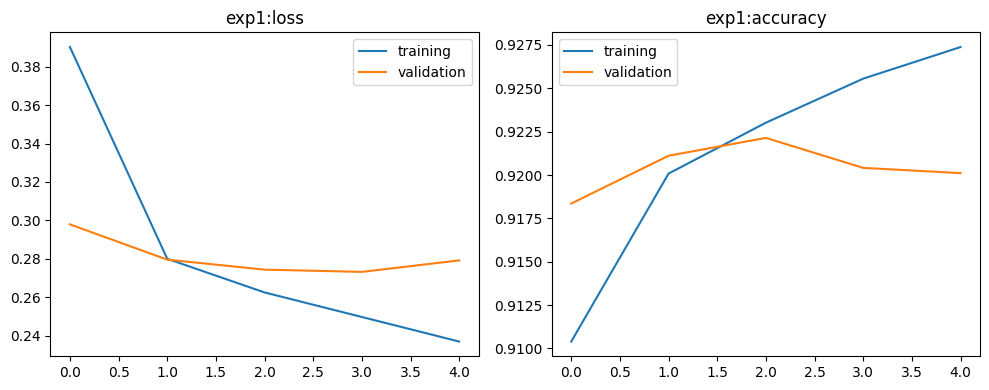

In [ ]:
hist_temp = 0

with open('/content/drive/MyDrive/Toxic Comments Filter/history_1-NUM_WORDS=10000-EPOCHS=5.pkl', 'rb') as handle:
    hist_temp = pickle.load(handle)

plot_learning_curves(hist_temp, "exp1")

* ### SETTAGGIO 2
* * NUM_WORDS=50000
* * EPOCHS=5
* * BATCH_SIZE=32
* * OPTIMIZER=ADAM
* * OUTPUT_EMBEDDING=16
* * BIDIRECTIONAL=FALSE
* * ARCHITETTURA=ARCH_1

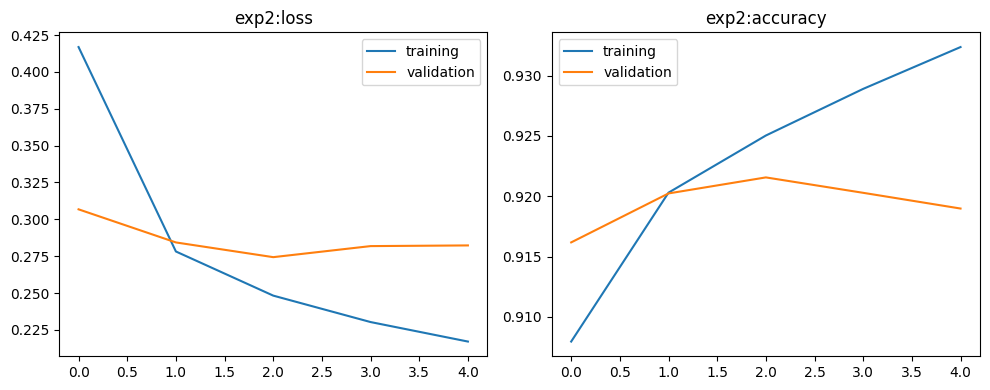

In [ ]:
hist_temp = 0

with open('/content/drive/MyDrive/Toxic Comments Filter/history_2_NUM_WORDS=50000-EPOCHS=5.pkl', 'rb') as handle:
    hist_temp = pickle.load(handle)

plot_learning_curves(hist_temp, "exp2")

* ### SETTAGGIO 3

* * NUM_WORDS=50000
* * EPOCHS=10
* * BATCH_SIZE=32
* * OPTIMIZER=ADAM
* * OUTPUT_EMBEDDING=16
* * BIDIRECTIONAL=FALSE
* * ARCHITETTURA=ARCH_1

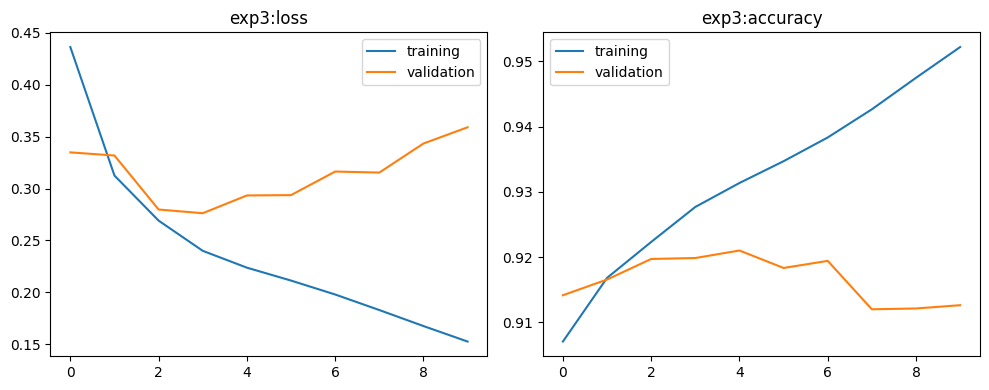

In [ ]:
hist_temp = 0

with open('/content/drive/MyDrive/Toxic Comments Filter/history_3_NUM_WORDS=50000-EPOCHS=10.pkl', 'rb') as handle:
    hist_temp = pickle.load(handle)

plot_learning_curves(hist_temp, "exp3")

* ### SETTAGGIO 4

* * NUM_WORDS=50000
* * EPOCHS=50
* * BATCH_SIZE=512
* * OPTIMIZER=ADAM
* * OUTPUT_EMBEDDING=16
* * BIDIRECTIONAL=FALSE
* * ARCHITETTURA=ARCH_1

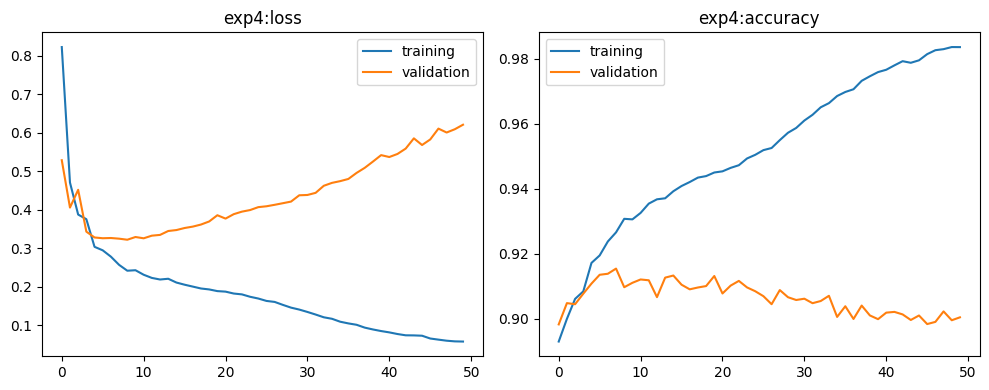

In [ ]:
hist_temp = 0

with open('/content/drive/MyDrive/Toxic Comments Filter/history_4_NUM_WORDS=50000-EPOCHS=50-BATCH_SIZE=512.pkl', 'rb') as handle:
    hist_temp = pickle.load(handle)

plot_learning_curves(hist_temp, "exp4")

* ### SETTAGGIO 5

* * NUM_WORDS=50000
* * EPOCHS=50
* * BATCH_SIZE=512
* * OPTIMIZER=RMSPROP
* * OUTPUT_EMBEDDING=16
* * BIDIRECTIONAL=FALSE
* * ARCHITETTURA=ARCH_1

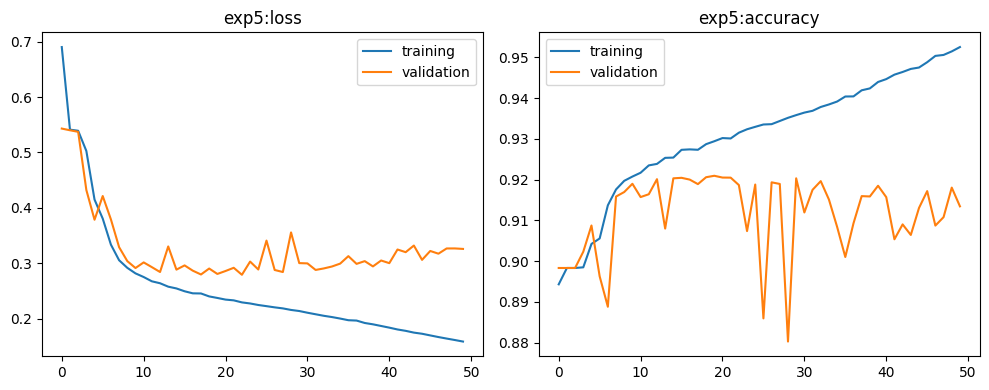

In [ ]:
hist_temp = 0

with open('/content/drive/MyDrive/Toxic Comments Filter/history_5_NUM_WORDS=50000-EPOCHS=50-BATCH_SIZE=512-OPTIMIZER=RMSPROP.pkl', 'rb') as handle:
    hist_temp = pickle.load(handle)

plot_learning_curves(hist_temp, "exp5")

* ### SETTAGGIO 6

* * NUM_WORDS=50000
* * EPOCHS=50
* * BATCH_SIZE=512
* * OPTIMIZER=RMSPROP
* * OUTPUT_EMBEDDING=32
* * BIDIRECTIONAL=FALSE
* * ARCHITETTURA=ARCH_1

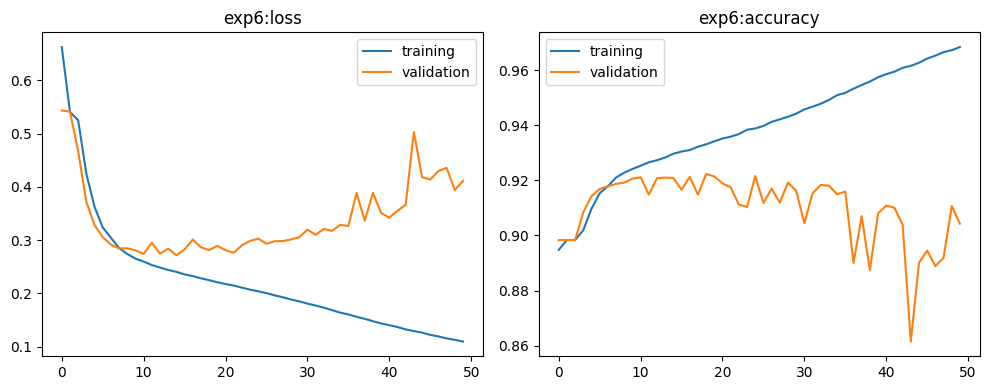

In [ ]:
hist_temp = 0

with open('/content/drive/MyDrive/Toxic Comments Filter/history_6_NUM_WORDS=50000-EPOCHS=50-BATCH_SIZE=512-OPTIMIZER=RMSPROP-OUTPUT_EMBEDDING=32.pkl', 'rb') as handle:
    hist_temp = pickle.load(handle)

plot_learning_curves(hist_temp, "exp6")

* ### SETTAGGIO 7

* * NUM_WORDS=50000
* * EPOCHS=100
* * BATCH_SIZE=512
* * OPTIMIZER=RMSPROP
* * OUTPUT_EMBEDDING=16
* * BIDIRECTIONAL=TRUE
* * ARCHITETTURA=ARCH_1

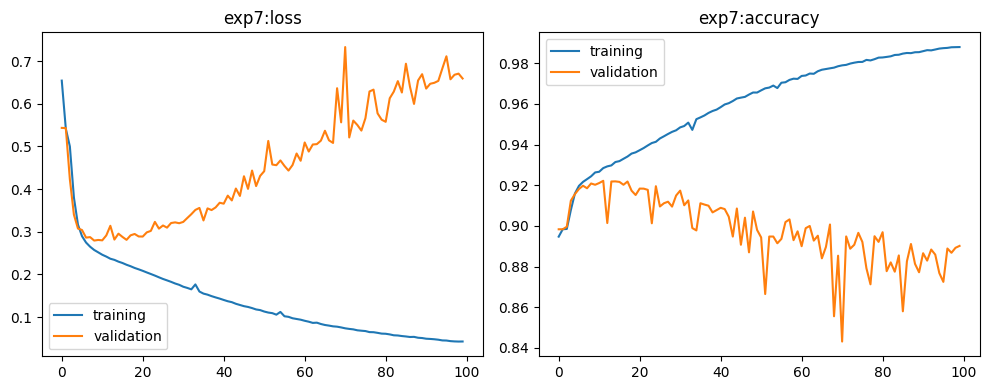

In [ ]:
hist_temp = 0

with open('/content/drive/MyDrive/Toxic Comments Filter/history_7_NUM_WORDS=50000-EPOCHS=100-BATCH_SIZE=512-OPTIMIZER=RMSPROP-OUTPUT_EMBEDDING=16-BIDIRECTIONAL=TRUE', 'rb') as handle:
    hist_temp = pickle.load(handle)

plot_learning_curves(hist_temp, "exp7")

* ### SETTAGGIO 8

* * NUM_WORDS=50000
* * EPOCHS=100
* * BATCH_SIZE=512
* * OPTIMIZER=RMSPROP
* * OUTPUT_EMBEDDING=16
* * BIDIRECTIONAL=TRUE
* * ARCHITETTURA=ARCH_2

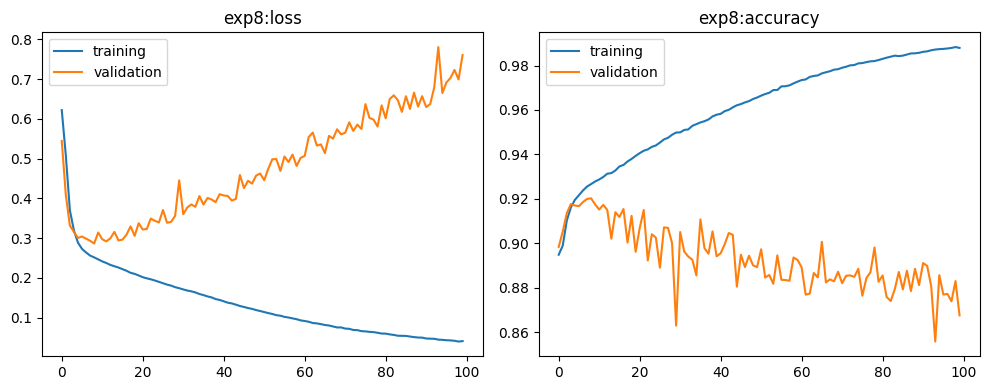

In [ ]:
hist_temp = 0

with open('/content/drive/MyDrive/Toxic Comments Filter/history_8_NUM_WORDS=50000-EPOCHS=100-BATCH_SIZE=512-OPTIMIZER=RMSPROP-OUTPUT_EMBEDDING=16-BIDIRECTIONAL=TRUE-ARCH_2', 'rb') as handle:
    hist_temp = pickle.load(handle)

plot_learning_curves(hist_temp, "exp8")

* ### SETTAGGIO 9

* * NUM_WORDS=10000
* * EPOCHS=100
* * BATCH_SIZE=512
* * OPTIMIZER=RMSPROP
* * OUTPUT_EMBEDDING=8
* * BIDIRECTIONAL=TRUE
* * ARCHITETTURA=ARCH_1

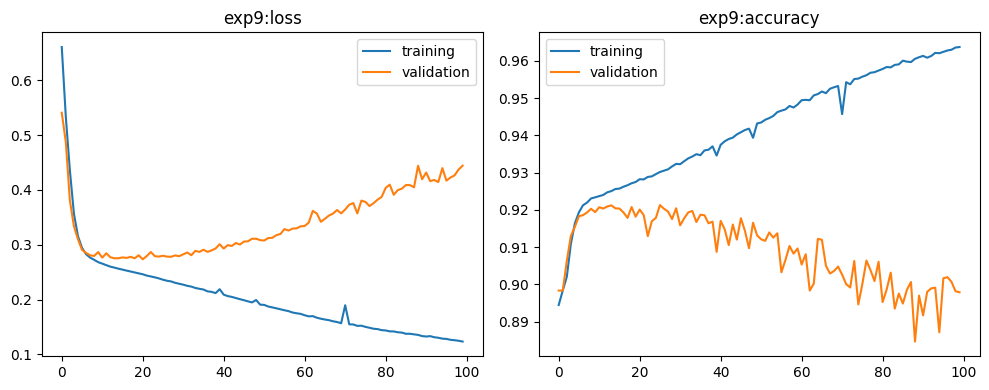

In [ ]:
hist_temp = 0

with open('/content/drive/MyDrive/Toxic Comments Filter/history_9_NUM_WORDS=10000-EPOCHS=100-BATCH_SIZE=512-OPTIMIZER=RMSPROP-OUTPUT_EMBEDDING=8-BIDIRECTIONAL=TRUE-ARCH_1', 'rb') as handle:
    hist_temp = pickle.load(handle)

plot_learning_curves(hist_temp, "exp9")

* ### SETTAGGIO 10

* * NUM_WORDS=10000
* * EPOCHS=100
* * BATCH_SIZE=512
* * OPTIMIZER=RMSPROP
* * OUTPUT_EMBEDDING=8
* * BIDIRECTIONAL=TRUE
* * ARCHITETTURA=ARCH_1
* * number_nodes_hidden_layer=32

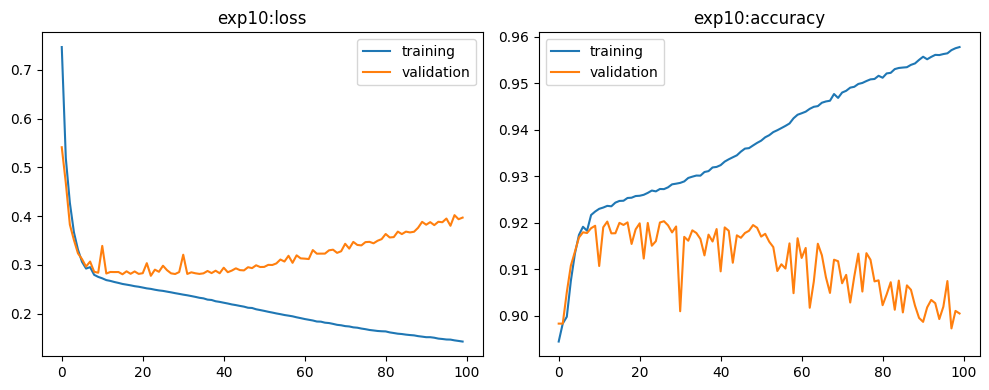

In [ ]:
hist_temp = 0

with open('/content/drive/MyDrive/Toxic Comments Filter/history_10_NUM_WORDS=10000-EPOCHS=100-BATCH_SIZE=512-OPTIMIZER=RMSPROP-OUTPUT_EMBEDDING=8-BIDIRECTIONAL=TRUE-ARCH_1-NUMBER_NODES_HIDDEN_LAYER=32', 'rb') as handle:
    hist_temp = pickle.load(handle)

plot_learning_curves(hist_temp, "exp10")

* ### SETTAGGIO 11

* * NUM_WORDS=10000
* * EPOCHS=100
* * BATCH_SIZE=512
* * OPTIMIZER=RMSPROP
* * OUTPUT_EMBEDDING=8
* * BIDIRECTIONAL=TRUE
* * ARCHITETTURA=ARCH_1
* * number_nodes_hidden_layer=16

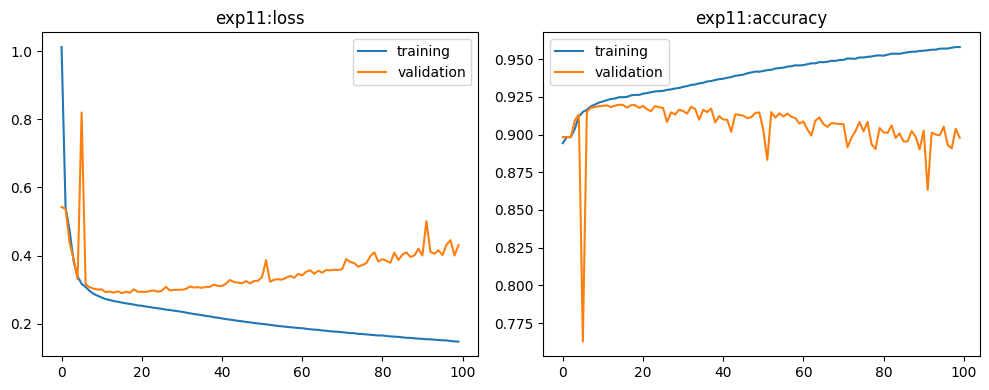

In [ ]:
hist_temp = 0

with open('/content/drive/MyDrive/Toxic Comments Filter/history_11_NUM_WORDS=10000-EPOCHS=100-BATCH_SIZE=512-OPTIMIZER=RMSPROP-OUTPUT_EMBEDDING=8-BIDIRECTIONAL=TRUE-ARCH_1-NUMBER_NODES_HIDDEN_LAYER=16', 'rb') as handle:
    hist_temp = pickle.load(handle)

plot_learning_curves(hist_temp, "exp11")

* ### SETTAGGIO 12

* * NUM_WORDS=10000
* * EPOCHS=100
* * BATCH_SIZE=128
* * OPTIMIZER=RMSPROP
* * OUTPUT_EMBEDDING=8
* * BIDIRECTIONAL=TRUE
* * ARCHITETTURA=ARCH_1
* * number_nodes_hidden_layer=8

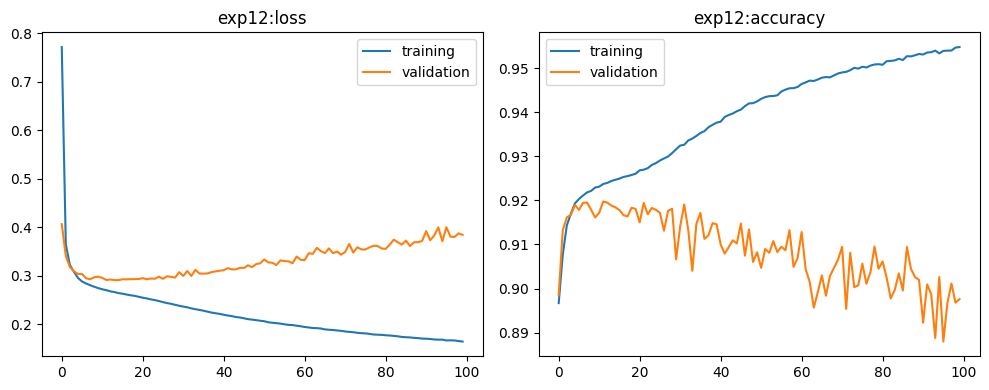

In [ ]:
hist_temp = 0

with open('/content/drive/MyDrive/Toxic Comments Filter/history_12_NUM_WORDS=10000-EPOCHS=100-BATCH_SIZE=128-OPTIMIZER=RMSPROP-OUTPUT_EMBEDDING=8-BIDIRECTIONAL=TRUE-ARCH_1-NUMBER_NODES_HIDDEN_LAYER=8', 'rb') as handle:
    hist_temp = pickle.load(handle)

plot_learning_curves(hist_temp, "exp12")

* ### SETTAGGIO 13

* * NUM_WORDS=10000
* * EPOCHS=100
* * BATCH_SIZE=128
* * OPTIMIZER=RMSPROP
* * OUTPUT_EMBEDDING=4
* * BIDIRECTIONAL=TRUE
* * ARCHITETTURA=ARCH_1
* * number_nodes_hidden_layer=16

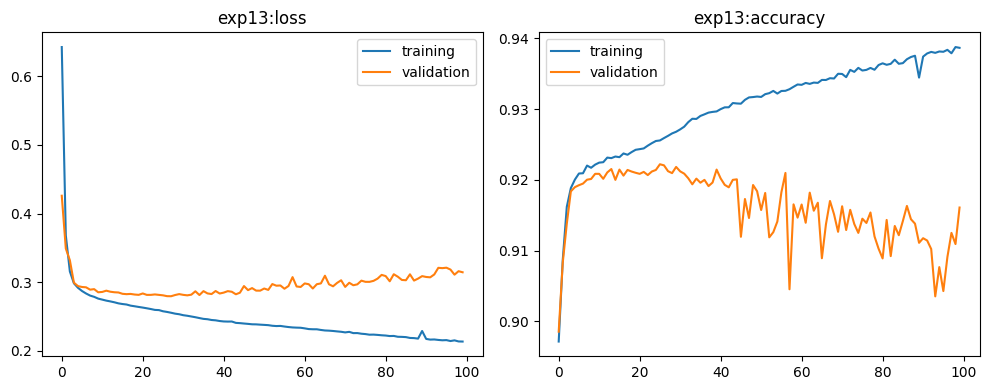

In [ ]:
hist_temp = 0

with open('/content/drive/MyDrive/Toxic Comments Filter/history_13_NUM_WORDS=10000-EPOCHS=100-BATCH_SIZE=128-OPTIMIZER=RMSPROP-OUTPUT_EMBEDDING=4-BIDIRECTIONAL=TRUE-ARCH_1-NUMBER_NODES_HIDDEN_LAYER=16', 'rb') as handle:
    hist_temp = pickle.load(handle)

plot_learning_curves(hist_temp, "exp13")

* ### SETTAGGIO 14

* * NUM_WORDS=10000
* * EPOCHS=100
* * BATCH_SIZE=128
* * OPTIMIZER=RMSPROP
* * OUTPUT_EMBEDDING=2
* * BIDIRECTIONAL=TRUE
* * ARCHITETTURA=ARCH_1
* * number_nodes_hidden_layer=16

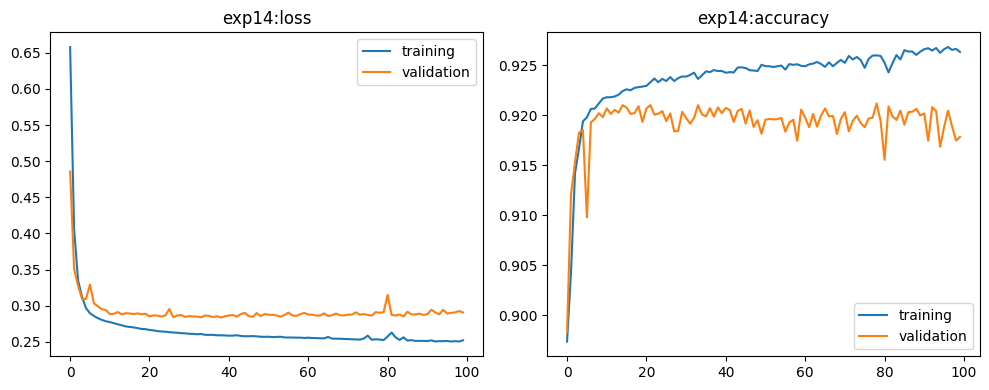

In [ ]:
hist_temp = 0

with open('/content/drive/MyDrive/Toxic Comments Filter/history_14_NUM_WORDS=10000-EPOCHS=100-BATCH_SIZE=128-OPTIMIZER=RMSPROP-OUTPUT_EMBEDDING=2-BIDIRECTIONAL=TRUE-ARCH_1-NUMBER_NODES_HIDDEN_LAYER=16', 'rb') as handle:
    hist_temp = pickle.load(handle)

plot_learning_curves(hist_temp, "exp14")

* ### SETTAGGIO 15

* * NUM_WORDS=5000
* * EPOCHS=100
* * BATCH_SIZE=32
* * OPTIMIZER=RMSPROP
* * OUTPUT_EMBEDDING=2
* * BIDIRECTIONAL=TRUE
* * ARCHITETTURA=ARCH_1
* * number_nodes_hidden_layer=16

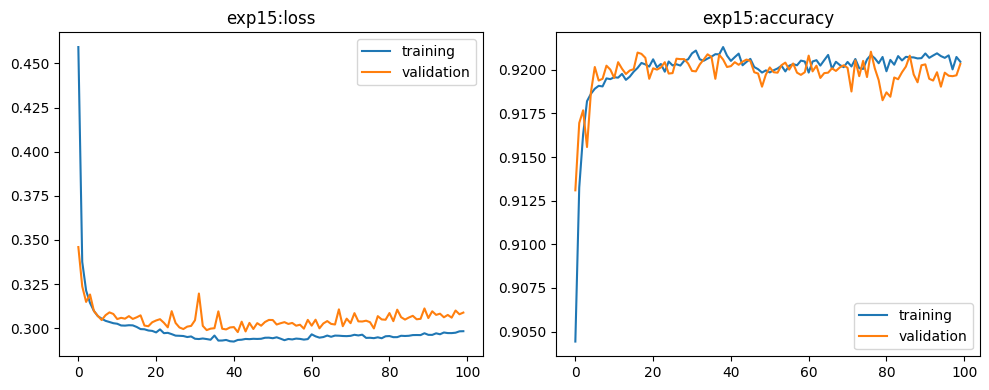

In [ ]:
hist_temp = 0

with open('/content/drive/MyDrive/Toxic Comments Filter/history_15_NUM_WORDS=5000-EPOCHS=100-BATCH_SIZE=32-OPTIMIZER=RMSPROP-OUTPUT_EMBEDDING=2-BIDIRECTIONAL=TRUE-ARCH_1-NUMBER_NODES_HIDDEN_LAYER=16', 'rb') as handle:
    hist_temp = pickle.load(handle)

plot_learning_curves(hist_temp, "exp15")

* ### SETTAGGIO 16

* * NUM_WORDS=5000
* * EPOCHS=100
* * BATCH_SIZE=32
* * OPTIMIZER=RMSPROP
* * OUTPUT_EMBEDDING=2
* * BIDIRECTIONAL=TRUE
* * ARCHITETTURA=ARCH_1
* * number_nodes_hidden_layer=128

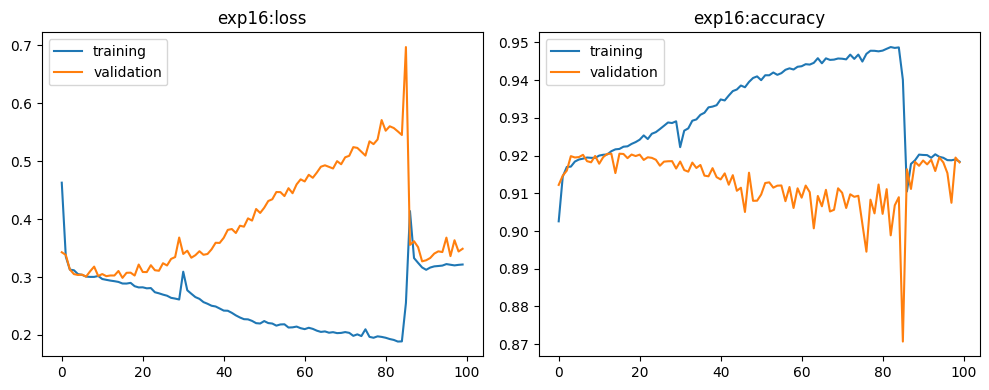

In [ ]:
hist_temp = 0

with open('/content/drive/MyDrive/Toxic Comments Filter/history_16_NUM_WORDS=5000-EPOCHS=100-BATCH_SIZE=32-OPTIMIZER=RMSPROP-OUTPUT_EMBEDDING=2-BIDIRECTIONAL=TRUE-ARCH_1-NUMBER_NODES_HIDDEN_LAYER=128', 'rb') as handle:
    hist_temp = pickle.load(handle)

plot_learning_curves(hist_temp, "exp16")

* ### SETTAGGIO 16

* * NUM_WORDS=5000
* * EPOCHS=100
* * BATCH_SIZE=32
* * OPTIMIZER=RMSPROP
* * OUTPUT_EMBEDDING=2
* * BIDIRECTIONAL=TRUE
* * ARCHITETTURA=ARCH_1
* * number_nodes_hidden_layer=128

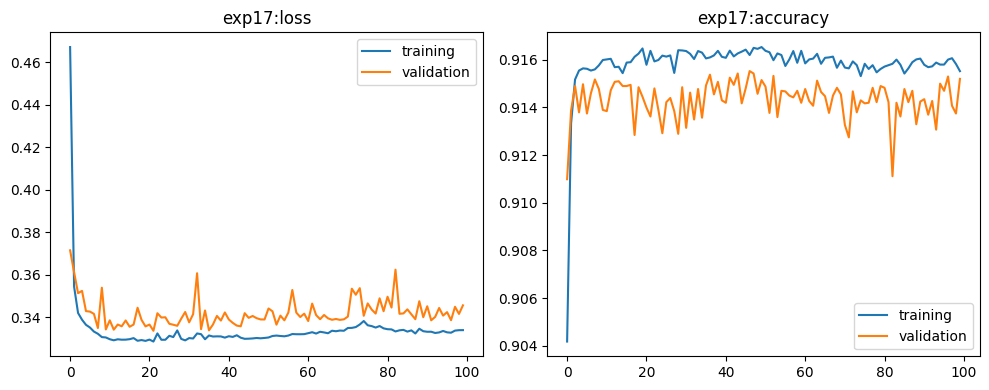

In [ ]:
hist_temp = 0

with open('/content/drive/MyDrive/Toxic Comments Filter/history_17_NUM_WORDS=1000-EPOCHS=100-BATCH_SIZE=32-OPTIMIZER=RMSPROP-OUTPUT_EMBEDDING=2-BIDIRECTIONAL=TRUE-ARCH_1-NUMBER_NODES_HIDDEN_LAYER=16', 'rb') as handle:
    hist_temp = pickle.load(handle)

plot_learning_curves(hist_temp, "exp17")

### Conclusioni


Il task asseganto è un problema di classificazione del sentiment di una frase di conseguenza l'architettura della rete che risolve questo task è quella RICORRENTE.

Sono state provare due architetture diverse, rispettivamente ARCH_1 e ARCH_2 e quella che ha dato dei risultati migliori è la prima, quella meno complessa.

Oltre a testare due architetture diverse sono stati anche provate diverse combinazioni degli IPERPARAMETRI della rete.

Come si può osservare la rete è molto sensibile alla dimensione degli EMBEDDINGS il cui layer è responsabile della maggior parte dei pesi della rete, informazione ottenuta tramite il metodo summary() applicato al modello.

Inoltre si può osservare che i risultati in fase di test hanno andamenti migliori al diminuire dell output degli embeddings, confermando cioè che la rete si trova in overfitting quando n (dimensione dell'output) è maggiore a 2.
Infatti dai grafici si può osservare che l andamento dell accuracy in fase di training aumenta mentre diminuisce in fase di test per n>2.

Altri parametri che si sono dimostrati fondamentali sono il BATCH_SIZE e il NUMERO DI LAYER, il primo impostato a 32 come da euristica proposta da Yann LeCun mentre il secondo impostato a 16 il quale dimostra che non è necessaria una rete complessa per ottenere delle ottime prestazioni circa 92% di accuratezza in fase di test.

In conclusione si può ritenersi soddisfatti dei risultati raggiunti (92% accuracy) e quindi usare questo modello per classificare una frase come contenente giudizi negativi o meno.